**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [23]:
# a. imports
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from types import SimpleNamespace
import time 

# b. our files
from problem1 import optimal_taxation_model
from problem2 import problem2_model
from problem3 import multistart_optimizer

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})


# c. reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

We decided to use sympy for this problem, since it is relatively simple. We basically just set the marginal utility to 0, to find the maximum value of the utility.

In [24]:
# a. setting the variables
alpha, kappa, nu, tau, sigma, rho, epsilon, w_, w, G, C, L = sm.symbols("alpha, kappa, nu, tau, sigma, rho, epsilon, w~tilde, w, G, C, L")

# b. Calculate C
C = kappa + w_*L

# c. calculate v
V = sm.ln(C**alpha * G**(1-alpha)) - nu*L**2/2

# d. differentiate v with L
V_diff = sm.diff(V,L)

# e. equal it to 0 and isolate L
sol = sm.solve(sm.Eq(V_diff,0),L)

# f. solution
sol[1]

(-kappa*nu + sqrt(nu*(4*alpha*w~tilde**2 + kappa**2*nu)))/(2*nu*w~tilde)

As we can see, this response is not exactly as we needed to prove, but we only need to isolate the nu parameter out of the root, and then the right equation emerges.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

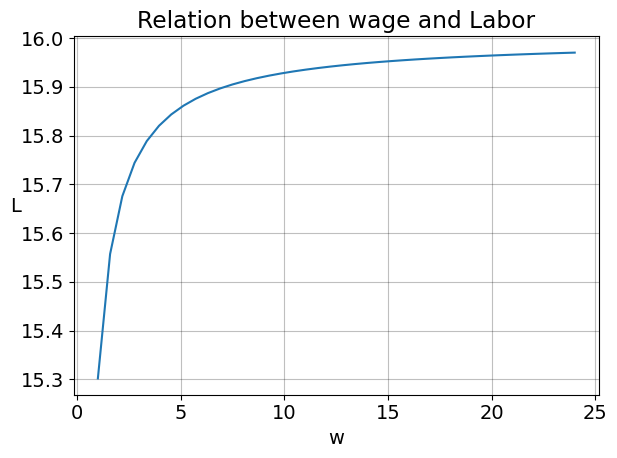

In [25]:
# a. initiate model
model1 = optimal_taxation_model()

# b. create wage vector
w_vector = np.linspace(1,24,40)

# c. simulate all L for all w
L_vector = []
for w_val in w_vector:
    L_val = model1.optimal_L(w_val,model1.par.tau)
    L_vector.append(L_val)

# d. create a subplot
ax = plt.subplot()

# e. plot
ax.plot(w_vector,L_vector)

# f. name labels
ax.set_xlabel("w")
ax.set_ylabel("L",rotation="horizontal")
ax.set_title("Relation between wage and Labor")

# g. show
plt.tight_layout()
plt.show()


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


c:\Users\lmigu\OneDrive\Documentos\Uni\Semestre 4 (Erasmus)\Programming\coding\projects-2023-the-best-duo\examproject\problem1.py:49: RuntimeWarning: invalid value encountered in double_scalars
  Labor = numerator / ((1-tau)*w*2)


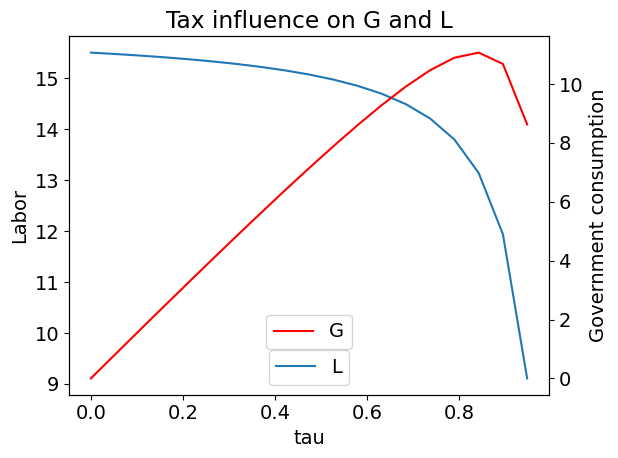

In [26]:
# a. create tau vector
tau_vector = np.linspace(0,1,20)

# b. simulate L and G for all values of tau
L_vector = []
G_vector = []

for tau_val in tau_vector:
    L_val = model1.optimal_L(model1.par.w,tau_val)
    G_val = model1.optimal_G(tau_val)
    L_vector.append(L_val)
    G_vector.append(G_val)

# c. create subplot
ax1= plt.subplot()

# d. plot
ax1.plot(tau_vector,L_vector)
ax2 = ax1.twinx()
ax2.plot(tau_vector,G_vector, color="red")

# e. name axis
ax1.set_ylabel("Labor")
ax2.set_ylabel("Government consumption")
ax1.set_xlabel("tau")
ax1.set_title("Tax influence on G and L")

# f. take out grid
ax1.grid(False)
ax2.grid(False)

# g. add legend
ax1.legend("L",loc = "lower center")
ax2.legend("G",loc = "lower center", bbox_to_anchor=(0.5, 0.1))

# h. show
plt.tight_layout()
plt.show()

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

The optimal tax rate is 0.515


c:\Users\lmigu\OneDrive\Documentos\Uni\Semestre 4 (Erasmus)\Programming\coding\projects-2023-the-best-duo\examproject\problem1.py:31: RuntimeWarning: divide by zero encountered in log
  utility = np.log(C**par.alpha * G**(1-par.alpha))


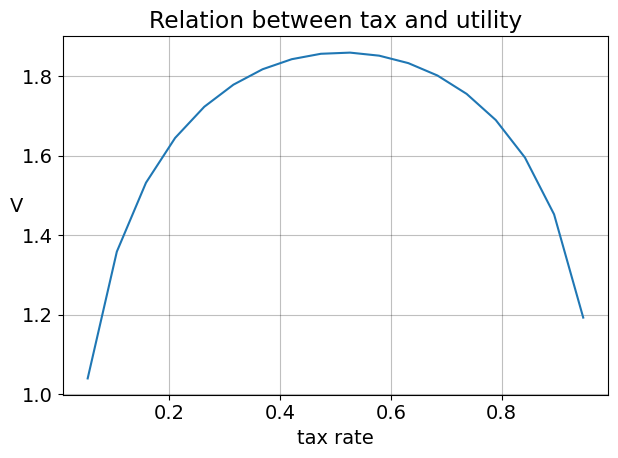

In [27]:
# a. solve for the optimal tau
sol_tau = model1.optimal_tau()

# b. print solution
print(f'The optimal tax rate is {sol_tau.x:.3f}')

# c. create a tau vector
tau_vector = np.linspace(0,1,20)

# d. simulate all V for all tau
V_vector = []
for tau_val in tau_vector:
    V_val = model1.V(tau_val,model1.optimal_G(tau_val),model1.optimal_L(1,tau_val))
    V_vector.append(V_val)

# e. create a subplot
ax = plt.subplot()

# f. plot
ax.plot(tau_vector,V_vector)

# g. name labels
ax.set_xlabel("tax rate")
ax.set_ylabel("V",rotation="horizontal")
ax.set_title("Relation between tax and utility")

# h. show
plt.tight_layout()
plt.show()


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.


**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [28]:
# a. solve for all sets
sol_G = np.empty((2,))
for i in range(2):
    sol_G[i] = model1.general_optimal_G(sol_tau.x,i).root

# b. print results
print(f" For the set 1, the optimal G is {sol_G[0]:.3f} \n",
      f"For the set 2, the optimal G is {sol_G[1]:.3f}")


 For the set 1, the optimal G is 7.711 
 For the set 2, the optimal G is 4.975


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [29]:
# a. solve for all sets
sol_tau = np.empty((2,))
for i in range(2):
    sol_tau[i] = model1.general_optimal_tau(i).x

# b. print results
print(f' The optimal tax rate for set 1 is {sol_tau[0]:.3f}\n',
      f'The optimal tax rate for set 2 is {sol_tau[1]:.3f}')

 The optimal tax rate for set 1 is 0.514
 The optimal tax rate for set 2 is 0.462


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

We decided to use sympy, since it is simple to use here.

In [30]:
# a. setting the variables
eta, kappa, l, w = sm.symbols("eta, kappa_t, l_t, w")

# b. calculate profits
profits_t = kappa*l**(1-eta)-w*l

# c. differentiate profits by l
diff_profits_t = sm.diff(profits_t,l)

# d. solve for l when derivative is zero
sm.solve(sm.Eq(diff_profits_t,0),l)[0]


(kappa_t*(1 - eta)/w)**(1/eta)

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [31]:
# a. setup the model
model2 = problem2_model()

# b. calculate H
H1 = model2.ex_ante(10000)

# c. print
print(f"The expected value of the salon is around {H1:.1f}")

The expected value of the salon is around 11.8


The expected value of the business is around 11,7.

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [32]:
# a. change delta
model2.par.delta = 0.05

# b. calculate H
H2 = model2.ex_ante(10000)

# c. building the answer
response = f"The expected value of the salon is around {H2:.1f} and it is"

if H2>H1:
    response += " higher than before."
else:
    response += " lower than before."

# d. print
print(response)

The expected value of the salon is around 12.6 and it is higher than before.


The expected value is higher than before, therefore it increases profitability.

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

The optimal delta is 0.041


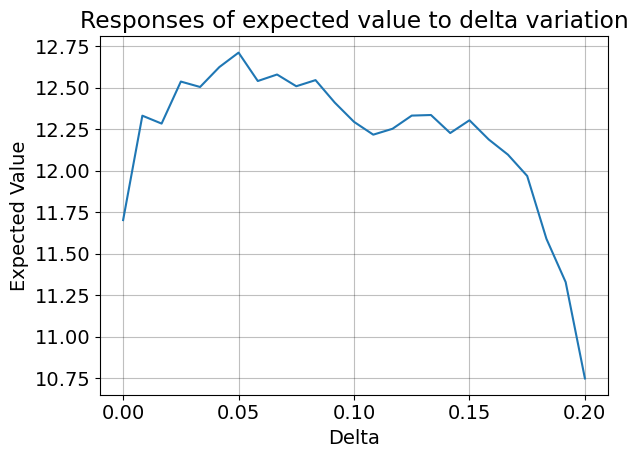

In [33]:
# a. solve for delta
sol_delta = model2.optimize_delta(1000)

# b. print answer
print(f"The optimal delta is {sol_delta.x:.3f}")

# c. create delta vector
delta_vector = np.linspace(0,0.2,25)

# d. solve for all values of delta
value_vector = []
for delta in delta_vector:
    model2.par.delta = delta
    value = model2.ex_ante(1000)
    value_vector.append(value)

# e. create sublot
ax = plt.subplot()

# f. plot values
ax.plot(delta_vector,value_vector)

# g. name labels
ax.set_xlabel("Delta")
ax.set_ylabel("Expected Value")
ax.set_title("Responses of expected value to delta variation")

# h. show
plt.tight_layout()
plt.show()


Our results show that the delta that maximizes H is between 0.03 and 0.06. Since it is a random distribution, it is difficult to pinpoint which is the actual result. It seems that there is a dip at delta=0.1 and another plateau until around 0.16 and then it decreases.


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



We were thinking of also changing w, adjusting it to profits. But, this would not increase profits, because it would only increase costs. Therefore we tried implementing an effort function in order to balance the effect of the wage on the cost by increasing the revenue through productivity. However we were unable to follow this through, since our model seemed to always break.

Our trial functions are inside problem2.py from line 127.

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [34]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

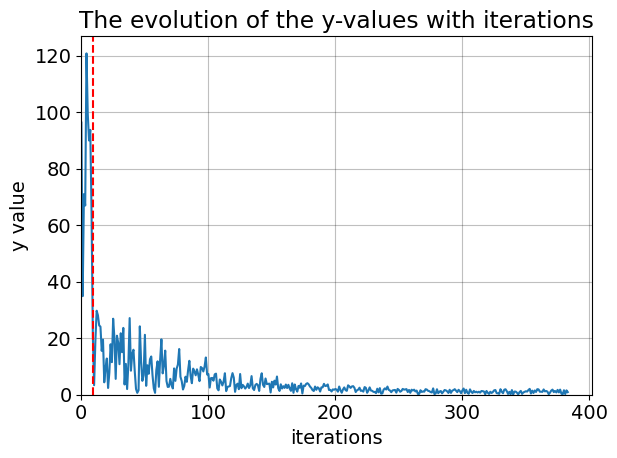

In [35]:
# a. set parameters
K_ = 10
K = 1000
bounds = [-600,600]
tau=10**-8

# b. get the values 
x_star, x_list = multistart_optimizer(griewank,bounds,tau,K_,K)

# c. calculate y values
y_list = []
for x in x_list:
    y = griewank(x)
    y_list.append(y)

# d. create subplot
ax = plt.subplot()

# e. plot
ax.plot(range(len(y_list)),y_list)
ax.axvline(x=K_-1, color='r', linestyle='--')

# f. name and set bounds to axis and title
ax.set_xlabel("iterations")
ax.set_ylabel("y value")
ax.set_title("The evolution of the y-values with iterations")
ax.set_xbound(0)
ax.set_ybound(0)

# g. show
plt.tight_layout()
plt.show()


As we can see, the values of y are very distant from the global minimum, since they move randomly. But, right after the red line, it starts to converge to the value of 0 that we wanted.

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [36]:
# a. set parameter
n = 10

# b. calculate times
t1_list = []
t2_list = []

for i in range(n):
    
    # i. calculate time for K_=10
    K_ = 10
    t1_start = time.time()
    multistart_optimizer(griewank,bounds,tau,K_,K)
    t1_end = time.time()

    # ii. calculate time for K_=100
    K_ = 100
    t2_start = time.time()
    multistart_optimizer(griewank,bounds,tau,K_,K)
    t2_end = time.time()
    
    # iii. record the times
    t1_list.append(t1_end-t1_start)
    t2_list.append(t2_end-t2_start)

# c. compute average
t1_average = sum(t1_list)/len(t1_list)
t2_average = sum(t2_list)/len(t2_list)

# d. building the answer
response = f"The average time when K_=10 is {t1_average:.3f},\n"
response += f"The average time when K_=100 is {t2_average:.3f}.\n"

if t1_average<t2_average:
    response += "Therefore its quicker when K_=10."
else:
    response += "Therefore its quicker when K_=100."

# d. print
print(response)


The average time when K_=10 is 0.955,
The average time when K_=100 is 1.130.
Therefore its quicker when K_=10.


According to our results, when K_ is 10 it converges faster. But the time elapsed with K_=10 seems to be more variable than when it is 100.